In [0]:
import numpy as np
import matplotlib.pyplot as plt

# Rating environment

In [0]:
N_FEATURES = 10
N_USERS = 20
N_MOVIES = 100
MAX_USERS = 300
MAX_MOVIES = 1000

# https://www.desmos.com/calculator/ftbdppvm03

## Helper functions

In [0]:
def generate_data(n_samples, n_features, rng=np.random.default_rng(), scheme="gauss", n_means=10, means_pol=5, pol=5, pol_threshold=1e-5):
    if scheme == "gauss":
        means = 2 * np.random.random((n_means, n_features)) - 1
        old_norms = np.linalg.norm(means, axis=1)
        for i in range(len(means)):
            means[i] = np.sign(means[i]) * np.abs(means[i]) ** means_pol
            means[i][np.abs(means[i]) < pol_threshold] = 0
        new_norms = np.linalg.norm(means, axis=1)
        for i in range(len(means)):
            means[i] *= old_norms[i] / new_norms[i]
        data = np.zeros((n_samples, n_features))
        batch_size = n_samples // n_means
        for i in range(n_means):
            data[batch_size*i:batch_size*(i+1)] = rng.multivariate_normal(means[i], np.identity(n_features)/n_features, batch_size)
        return means, data

    elif scheme == "polarized":
        data = 2 * rng.random((n_samples, n_features)) - 1
        for i in range(len(data)):
            polarization = rng.choice(pol-2) + 2
            data[i] = np.sign(data[i]) * np.abs(data[i]) ** polarization
            data[i][np.abs(data[i]) < pol_threshold] = 0
        return data
    else:
        raise ValueError("unknown scheme")

def cosine_similarity(user, movie):
    return np.dot(user, movie) / (np.linalg.norm(user) * np.linalg.norm(movie))

def reward_func(user, movie):
    """return cosine similarity somewhat polarized, then scaled and shifted between 0 and 5"""
    x = cosine_similarity(user, movie)
    if x == -1:
        return -1
    x = 0.5 * (x + 1)
    x = 1 / (1 + (((1-x)/x)**1.5))
    return x * 2 - 1

def get_rewards_matrix(users, movies, reward_f=reward_func):
    n_users, n_movies = len(users), len(movies)
    res = np.zeros((n_users, n_movies))
    for i in range(n_users):
        for j in range(n_movies):
            res[i][j] = reward_f(users[i], movies[j])
    return res

def get_seen_matrix(n_users, n_movies, history):
    res = np.zeros((n_users, n_movies))
    for user_idx, movie_idx in history:
        res[user_idx][movie_idx] = 1
    return res

## Environment

In [0]:
class Environment:
    
    def __init__(self, 
                 n_features=N_FEATURES, 
                 max_users=MAX_USERS,
                 max_movies=MAX_MOVIES,
                 n_users=N_USERS, 
                 n_movies=N_MOVIES,
                 history=None, 
                 reward_f=reward_func, 
                 context_size=10,
                 a=0.05,
                 b=0.025,
                 c=3,
                 d=0,
                 quit_prob_init=0.05,
                 subscription_rate=20,
                 seed=None):
      
        self.reset(n_features=n_features, max_users=max_users, 
                   max_movies=max_movies, n_users=n_users, n_movies=n_movies, 
                   history=history, reward_f=reward_f, 
                   context_size=context_size, a=a, b=b, c=c, d=d, 
                   quit_prob_init=quit_prob_init, 
                   subscription_rate=subscription_rate, seed=seed)
        
    def reset(self, n_features=N_FEATURES, max_users=MAX_USERS, 
              max_movies=MAX_MOVIES, n_users=N_USERS, n_movies=N_MOVIES, 
              history=None, reward_f=reward_func, context_size=10, 
              a=0.05, b=0.025, c=3, d=0, quit_prob_init=0.05, 
              subscription_rate=20, seed=None):
        self.n_features = n_features
        self.max_users = max_users
        self.max_movies = max_movies
        self.n_users = n_users
        self.optimal_users = n_users
        self.n_movies = n_movies
        self.context_size = context_size
        self.quit_prob_init = quit_prob_init
        self.subscription_rate = subscription_rate
        self.rng = np.random.default_rng(seed)

        self.users = generate_data(max_users, n_features, self.rng, scheme="polarized")
        self.means, self.movies = generate_data(max_movies, n_features, self.rng, scheme="gauss")
        self.movies_with_noise = self.movies + self.rng.normal(0, 0.01, self.movies.shape)
        self.rewards_matrix = get_rewards_matrix(self.users, self.movies, reward_f)
        self.status_users = np.zeros(max_users)
        self.status_movies = np.zeros(max_movies)
        self.quit_probabilities = np.zeros(max_users) + quit_prob_init
        self.init_status()

        self.get_update_prob_coeff = lambda x : -a / (1 + np.exp(-(c*x-d))) + b
        self.history = [] if history is None else history
        self.seen_matrix = get_seen_matrix(self.max_users, self.max_movies, self.history)
        self.step_count_tracker = 0
    
    def add_movie(self, movie_idx=None):
        if movie_idx is None:
            not_airing = np.nonzero(self.status_movies == 0)[0]
            n = len(not_airing)
            if n > 0:
                self.status_movies[not_airing[self.rng.choice(n)]] = 1
        else:
            assert self.status_movies[movie_idx] == 0, "trying to add a movie which is already airing"
            self.status_movies[movie_idx] = 1
        self.n_movies += 1

    def add_user(self, user_idx=None):
        if user_idx is None:
            not_subscribed = np.nonzero(self.status_users == 0)[0]
            n = len(not_subscribed)
            if n > 0:
                user_idx = not_subscribed[self.rng.choice(n)]
                self.status_users[user_idx] = 1
                self.quit_probabilities[user_idx] = self.quit_prob_init
        else:
            assert self.status_users[user_idx] == 0, "trying to add a user which is already subscribed"
            self.status_users[user_idx] = 1
            self.quit_probabilities[user_idx] = self.quit_prob_init
        self.n_users += 1
        self.optimal_users += 1

    def get_reward(self, user_idx, movie_idx, context):
        """returns a binary reward"""
        reward = self.rewards_matrix[user_idx][movie_idx]
        
        # keep best choice consequences for regret computations
        best_reward = np.max([self.rewards_matrix[user_idx][m_idx] for m_idx in context])
        optimal_quit_prob = self.quit_probabilities[user_idx] + self.get_update_prob_coeff(best_reward)
        optimal_quit_prob = max(0, min(1, optimal_quit_prob))
        self.optimal_users -= optimal_quit_prob

        self.update_probability(user_idx, reward)
        self.update_quit(user_idx)

        self.update_history(user_idx, movie_idx, reward, best_reward, self.n_users, self.optimal_users, context)

        return 1 if reward > 0 else -1
    
    def get_next_step(self):
        self.step_count_tracker += 1
        if self.step_count_tracker % self.subscription_rate == 0:
            self.add_user()
        subscribed_users = np.nonzero(self.status_users == 1)[0]
        if len(subscribed_users) == 0:
            return -2, None
        else:
            user_permutation = self.rng.permutation(subscribed_users)
            for user_idx in user_permutation:  # try until you can suggest a movie to a user
                seen_movies = np.nonzero(self.seen_matrix[user_idx])[0]
                airing_movies = np.nonzero(self.status_movies)[0]
                available_movies = list(set(airing_movies) - set(seen_movies))
                if len(available_movies) > 0:
                    self.rng.shuffle(available_movies)
                    context = available_movies[:self.context_size]
                    return user_idx, context
        # if the users have seen all the movies that are airing
            return -1, None
    
    def init_status(self):
        users_init = self.rng.choice(self.max_users, self.n_users, replace=False)
        movies_init = self.rng.choice(self.max_movies, self.n_movies, replace=False)
        self.status_users[users_init] = 1
        self.status_movies[movies_init] = 1

    def remove_movie(self, movie_idx=None, definitely=True):
        new_status = -1 if definitely else 0  # -1 if definitely else 0
        if movie_idx is None:
            airing = np.nonzero(self.status_movies == 1)[0]
            n = len(airing)
            if n > 0:
                self.status_movies[airing[self.rng.choice(n)]] = new_status
        else:
            assert self.status_movies[movie_idx] == 1, "trying to remove a movie which is not airing"
            self.status_movies[movie_idx] = new_status
        self.n_movies -= 1

    def remove_user(self, user_idx=None, definitely=True):
        new_status = -1 if definitely else 0  # -1 if definitely else 0
        if user_idx is None:
            subscribed = np.nonzero(self.status_users == 1)[0]
            n = len(subscribed)
            if n > 0:
                self.status_users[subscribed[self.rng.choice(n)]] = new_status
        else:
            assert self.status_users[user_idx] == 1, "trying to remove a user which is not subscribed"
            self.status_users[user_idx] = new_status
        self.n_users -= 1

    def update_history(self, user_idx, movie_idx, reward, best_reward, n_users, optimal_users, context):
        self.history.append((user_idx, movie_idx, reward, best_reward, n_users, optimal_users, context))
        self.seen_matrix[user_idx][movie_idx] = 1

    def update_probability(self, user_idx, reward):
        self.quit_probabilities[user_idx] += self.get_update_prob_coeff(reward)
        self.quit_probabilities[user_idx] = max(0, min(1, self.quit_probabilities[user_idx]))
    
    def update_quit(self, user_idx):
      """updates the available users list by generating either 0 (not quit) or (1 quit) using the probability that the user will quit"""
      will_quit = self.rng.binomial(1, self.quit_probabilities[user_idx])
      if will_quit:
        self.remove_user(user_idx)

## Agents

In [0]:
class RandomAgent:
    
    def __init__(self, seed=None):
        self.rng = np.random.default_rng(seed)
        self.agent_history = []
    
    def recommend(self, user_idx, context):
        return context[self.rng.choice(len(context))]

    def update_history(self, user_idx, movie_idx, reward, context):
        """ updating history for the future decisions of the agent """
        self.agent_history.append([user_idx, movie_idx, reward, context])

In [0]:
class EpsilonGreedyAgent:
    """ Epsilon greedy agent. """

    def __init__(self, 
                 movies_with_noise,
                 at_start_exploration_iters=10, 
                 lr=.1, 
                 epsilon=0,
                 seed=None):
        self._movies_with_noise = movies_with_noise
        self.at_start_exploration_iters = at_start_exploration_iters
        self._epsilon = epsilon
        self._rng = np.random.default_rng(seed)
        self.agent_history = []
        
    def recommend(self, user_idx, context):
        if(len(self.agent_history) < self.at_start_exploration_iters) or self._rng.random() < self._epsilon: # exploration at start and building some history
          recommended_movie = context[self._rng.choice(len(context))]
        else: # maxing based on similarity with the already known movies
        # checking if the user already has noted a movie:
            already_rated_users = [h[0] for h in self.agent_history]
            if user_idx in already_rated_users: # if the user already exists
                user_movies = [h for h in self.agent_history if h[0] == user_idx]
                self._rng.shuffle(user_movies)
                best_reward = np.argmax([x[2] for x in user_movies])
                best_movie_idx = user_movies[best_reward][1]
                reward_pred = self.similarities(best_movie_idx, context)
                recommended_movie = context[np.argmax(reward_pred)]  # the action is the index of the chosen movie
            else: # if we don't know anything yet about the user we select randomly
                recommended_movie = context[self._rng.choice(len(context))]
        return recommended_movie

    def similarities(self, best_movie_idx, context):
      return [self.similarity(self._movies_with_noise[best_movie_idx], self._movies_with_noise[movie_idx]) for movie_idx in context]

    def similarity(self, item1, item2):
      return np.dot(item1, item2) / (np.linalg.norm(item1) * np.linalg.norm(item2))
    
    def update_history(self, user_idx, movie_idx, reward, context):
        """ updating history for the future decisions of the agent """
        self.agent_history.append([user_idx, movie_idx, reward, context])

In [0]:
env = Environment(seed=42)

In [0]:
def run_exp(env, agent_type="random", horizon=1000, should_reset=True, seed=None):
    if should_reset:
        env.reset(seed=seed)
    if agent_type == "Random":
        agent = RandomAgent(seed=seed)
    elif agent_type == "EG":
        agent = EpsilonGreedyAgent(env.movies_with_noise, seed=seed)
    elif agent_type == "DL":
        agent = DLAgent(model=triplet_model, seed=seed)
    else:
        raise ValueError("agent_type unknown")
    for i in range(horizon):
        user_idx, context = env.get_next_step()
        if user_idx == -2:
            break
        elif user_idx != -1:
            movie_idx = agent.recommend(user_idx, context)
            reward = env.get_reward(user_idx, movie_idx, context)
            agent.update_history(user_idx, movie_idx, reward, context)
    n_users = [h[4] for h in env.history]
    optimal_users = [h[5] for h in env.history]
    cum_regrets = [h[5] - h[4] for h in env.history]
    return cum_regrets, n_users, optimal_users, env.history

In [0]:
cum_regretsRandom, n_usersRandom, optimal_usersRandom, _ = run_exp(env, agent_type="Random", horizon=1000, seed=None)
cum_regretsEG, n_usersEG, optimal_usersEG, _ = run_exp(env, agent_type="EG", horizon=1000, seed=None)

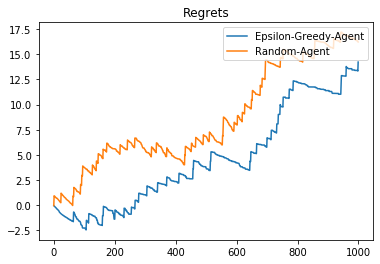

In [26]:
plt.plot(cum_regretsEG, label='EG')
plt.plot(cum_regretsRandom, label='Random')
plt.legend(('Epsilon-Greedy-Agent', 'Random-Agent'),loc='upper right')
plt.title("Regrets")
plt.show()

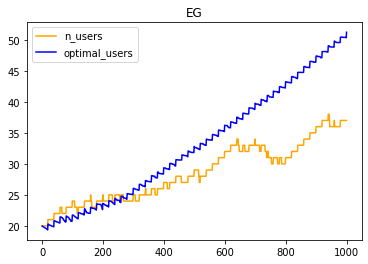

In [27]:
plt.plot(n_usersEG, label='n_users', c="orange")
plt.plot(optimal_usersEG, label='optimal_users', c="blue")
plt.legend()
plt.title('EG')
plt.show()

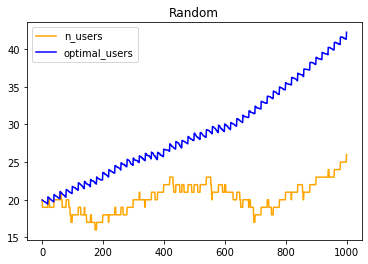

In [29]:
plt.plot(n_usersRandom, label='n_users', c="orange")
plt.plot(optimal_usersRandom, label='optimal_users', c="blue")
plt.legend()
plt.title('Random')
plt.show()

### The model of the DL agent:
based on the triplet loss model of the implicit feedback

In [13]:
import tensorflow as tf
from tensorflow.keras import layers


def identity_loss(y_true, y_pred):
    """Ignore y_true and return the mean of y_pred
    
    This is a hack to work-around the design of the Keras API that is
    not really suited to train networks with a triplet loss by default.
    """
    return tf.reduce_mean(y_pred)


class MarginLoss(layers.Layer):

    def __init__(self, margin=1.):
        super().__init__()
        self.margin = margin
        
    def call(self, inputs):
        pos_pair_similarity = inputs[0]
        neg_pair_similarity = inputs[1]
        
        diff = neg_pair_similarity - pos_pair_similarity
        return tf.maximum(diff + self.margin, 0.)

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Flatten, Input, Dense
from tensorflow.keras.layers import Lambda, Dot
from tensorflow.keras.regularizers import l2


class TripletModel(Model):
    def __init__(self, n_users, n_items, latent_dim=32,
                 l2_reg=None, margin=1.):
        super().__init__(name="TripletModel")
        
        self.margin = margin
        
        l2_reg = None if l2_reg == 0 else l2(l2_reg)

        self.user_layer = Embedding(n_users, latent_dim,
                                    input_length=1,
                                    input_shape=(1,),
                                    name='user_embedding',
                                    embeddings_regularizer=l2_reg)
    
        # The following embedding parameters will be shared to
        # encode both the positive and negative items.
        self.item_layer = Embedding(n_items, latent_dim,
                                    input_length=1,
                                    name="item_embedding",
                                    embeddings_regularizer=l2_reg)
        
        # The 2 following layers are without parameters, and can
        # therefore be used for both positive and negative items.
        self.flatten = Flatten()
        self.dot = Dot(axes=1, normalize=True)
        self.margin_loss = MarginLoss(margin)
        
    def call(self, inputs, training=False):
        user_input = inputs[0]
        pos_item_input = inputs[1]
        neg_item_input = inputs[2]
        
        user_embedding = self.user_layer(user_input)
        user_embedding = self.flatten(user_embedding)
        
        pos_item_embedding = self.item_layer(pos_item_input)
        pos_item_embedding = self.flatten(pos_item_embedding)
        
        neg_item_embedding = self.item_layer(neg_item_input)
        neg_item_embedding = self.flatten(neg_item_embedding)
        
        # Similarity computation between embeddings
        pos_similarity = self.dot([user_embedding, pos_item_embedding])
        neg_similarity = self.dot([user_embedding, neg_item_embedding])
                
        return self.margin_loss([pos_similarity, neg_similarity])
    

triplet_model = TripletModel(n_users=MAX_USERS+1, n_items=MAX_MOVIES+1,
                             latent_dim=64, l2_reg=1e-6)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### training for the deep agent:


In [0]:
env.reset(seed=42)

In [0]:
agentRandom = RandomAgent()

In [0]:
def generate_data_for_NN(env,agent,iters=1000,seed=None):
  """generates data to trail the model of the DL agent """
  data=[]
  for i in range(iters):
    user_idx, context = env.get_next_step()
    if user_idx == -2:
            break
    elif user_idx != -1:
            movie_idx = agent.recommend(user_idx, context)
            reward = env.get_reward(user_idx, movie_idx, context)
            agent.update_history(user_idx, movie_idx, reward, context)
            data.append([user_idx,movie_idx,reward])
  return data
def get_pos_data(data):
  pos_data=[d  for d in data if d[2] > 0]
  return pos_data

In [0]:
generated_NN_training_data=generate_data_for_NN(env,agentRandom,iters=10000,seed=None) #10000 is equivalent to 3.33% of the possible User x Movie
pos_data_train=get_pos_data(generated_NN_training_data)

In [0]:
# pos_data_test=get_pos_data(generate_data_for_NN(env,agentRandom,iters=100,seed=None))

In [0]:
# training the triplet model
def sample_triplets(pos_data, max_item_id=1000, random_seed=0):
    """Sample negatives at random"""
    rng = np.random.RandomState(random_seed)
    user_ids = np.asarray([d[0] for d in pos_data])
    pos_item_ids = np.asarray([d[1] for d in pos_data])

    neg_item_ids = rng.randint(low=1, high=max_item_id + 1,
                               size=len(user_ids))

    return [user_ids, pos_item_ids, neg_item_ids]

In [35]:
# we plug the identity loss and the a fake target variable ignored by
# the model to be able to use the Keras API to train the triplet model
fake_y = np.ones_like([d[0] for d in pos_data_train])
triplet_model.compile(loss=identity_loss, optimizer="adam")

n_epochs = 10
batch_size = 64
triplet_inputs = sample_triplets(pos_data_train, max_item_id=1000,
                                     random_seed=None)
triplet_model.fit(x=triplet_inputs, y=fake_y, shuffle=True,
                      batch_size=64, epochs=10)

Train on 5361 samples
Epoch 1/10
5361/5361 [==============================] - 0s 73us/sample - loss: 0.7319
Epoch 2/10
5361/5361 [==============================] - 0s 36us/sample - loss: 0.1681
Epoch 3/10
5361/5361 [==============================] - 0s 42us/sample - loss: 0.0991
Epoch 4/10
5361/5361 [==============================] - 0s 41us/sample - loss: 0.0806
Epoch 5/10
5361/5361 [==============================] - 0s 38us/sample - loss: 0.0735
Epoch 6/10
5361/5361 [==============================] - 0s 39us/sample - loss: 0.0686
Epoch 7/10
5361/5361 [==============================] - 0s 37us/sample - loss: 0.0641
Epoch 8/10
5361/5361 [==============================] - 0s 37us/sample - loss: 0.0609
Epoch 9/10
5361/5361 [==============================] - 0s 40us/sample - loss: 0.0582
Epoch 10/10
5361/5361 [==============================] - 0s 37us/sample - loss: 0.0559


In [36]:
from keras.models import load_model

class DLAgent():
  def __init__(self, model,seed=None):
    self.model=model
    self._current_triplet=None
  def recommend(self,user_idx,context):
    # since the model takes as input a triplet we will generate the triplets from the context(available movies indices)
    user_ids=np.asarray([user_idx for i in range(len(context))])
    pos_items=np.asarray(context)
    neg_items=np.asarray([context[i-1] for i in range(len(context))])  # generating the neg item by doing a circular rotation so we dont have the same movie as pos and neg
    triplets=[user_ids,pos_items,neg_items]
    pred_rewards=self.model.predict(triplets)
    index=np.argmax(pred_rewards)
    self._current_triplet=[np.asarray([user_idx]),np.asarray([pos_items[index]]),np.asarray([neg_items[index]])]
    return pos_items[index]

  def update_history(self, user_idx, movie_idx, reward, context):
    if reward > 0:
      # self.model.save_weights('weights.h5') 
      # self.model.load_weights('weights.h5')
      self.model.fit(self._current_triplet)

Using TensorFlow backend.


In [0]:
# triplet_model.predict(item)

In [0]:
cum_regretsDL, n_usersDL, optimal_usersDL, _ = run_exp(env, agent_type="DL", horizon=1000, seed=42)

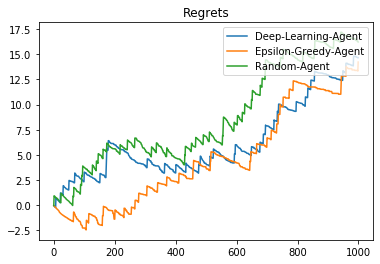

In [41]:
plt.plot(cum_regretsDL, label='DL')
plt.plot(cum_regretsEG, label='EG')
plt.plot(cum_regretsRandom, label='Random')
plt.legend(('Deep-Learning-Agent','Epsilon-Greedy-Agent', 'Random-Agent'),loc='upper right')
plt.title("Regrets")
plt.show()

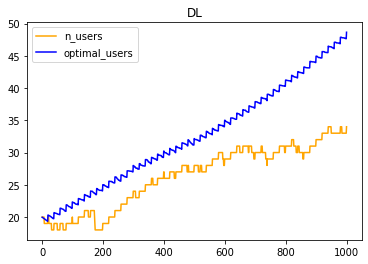

In [44]:
plt.plot(n_usersDL, label='n_users', c="orange")
plt.plot(optimal_usersDL, label='optimal_users', c="blue")
plt.legend()
plt.title('DL')
plt.show()